# Vehicle Detection

## 1. Search and Classify

In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split


In [2]:
def convert_color(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
        
    return feature_image
            

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec,
                                  block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec,
                       block_norm='L2-Hys')
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, color_space)            
            
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


## Histogram of Oriented Gradients (HOG)

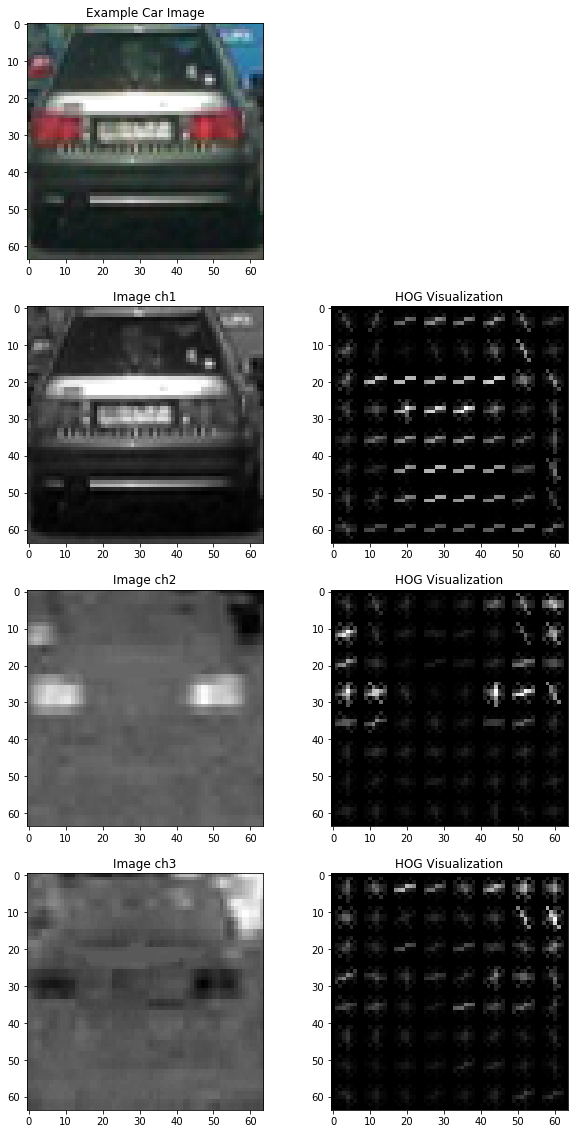

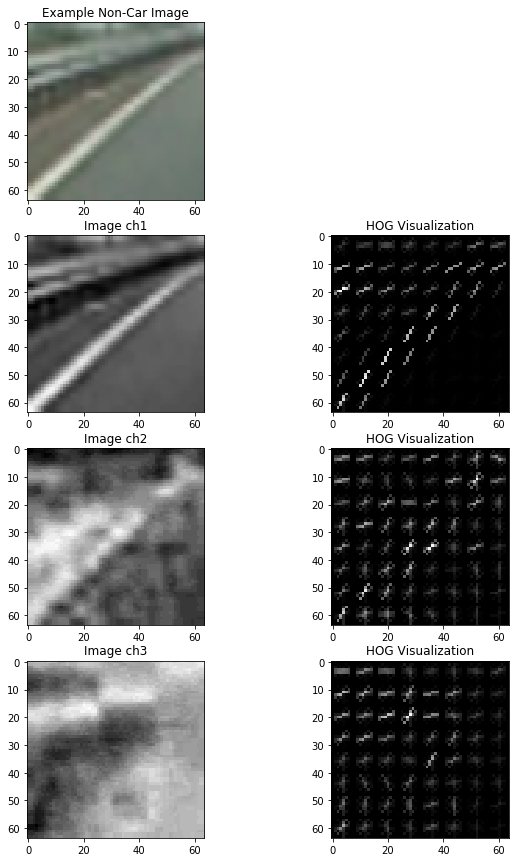

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

# Read in our vehicles and non-vehicles
hog_cars = []
hog_notcars = []

hog_images = glob.glob('./labeled_data/vehicles/GTI_MiddleClose/image0115.png')
for hog_image in hog_images:
    hog_cars.append(hog_image)

hog_images = glob.glob('./labeled_data/non-vehicles/GTI/image13.png')
for hog_image in hog_images:
    hog_notcars.append(hog_image)
        

# Generate a random index to look at a car image
ind = np.random.randint(0, len(hog_cars))
# Read in the image
hog_image = mpimg.imread(hog_cars[ind])

# Parameters
hog_channel = 0
#color_conv = 'cv2.COLOR_RGB2RGB'


#conv_ch1 = ch1
#conv_ch2 = ch2
#conv_ch3 = ch3

conv_img = cv2.cvtColor(hog_image, cv2.COLOR_RGB2YCrCb)

conv_ch1 = conv_img[:,:,0]
conv_ch2 = conv_img[:,:,1]
conv_ch3 = conv_img[:,:,2]

# Define HOG parameters
hog_orient = 9
hog_pix_per_cell = 8
hog_cell_per_block = 2
# Call our function with vis=True to see an image output
hog_features, hog_image_out1 = get_hog_features(conv_ch1, hog_orient, 
                        hog_pix_per_cell, hog_cell_per_block, 
                        vis=True, feature_vec=False)
hog_features, hog_image_out2 = get_hog_features(conv_ch2, hog_orient, 
                        hog_pix_per_cell, hog_cell_per_block, 
                        vis=True, feature_vec=False)
hog_features, hog_image_out3 = get_hog_features(conv_ch3, hog_orient, 
                        hog_pix_per_cell, hog_cell_per_block, 
                        vis=True, feature_vec=False)
# Plot the examples
fig = plt.figure(figsize=(10,20))
plt.subplot(421)
plt.imshow(hog_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(423)
plt.imshow(conv_ch1, cmap='gray')
plt.title('Image ch1')
plt.subplot(425)
plt.imshow(conv_ch2, cmap='gray')
plt.title('Image ch2')
plt.subplot(427)
plt.imshow(conv_ch3, cmap='gray')
plt.title('Image ch3')

#plt.subplot(422)
#plt.imshow(hog_image_out2, cmap='gray')
#plt.title('HOG Visualization')
plt.subplot(424)
plt.imshow(hog_image_out1, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(426)
plt.imshow(hog_image_out2, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(428)
plt.imshow(hog_image_out3, cmap='gray')
plt.title('HOG Visualization')
plt.show()

# Non-Car
# Generate a random index to look at a car image
ind = np.random.randint(0, len(hog_notcars))
# Read in the image
hog_image = mpimg.imread(hog_notcars[ind])

# Parameters
hog_channel = 0
#color_conv = 'cv2.COLOR_RGB2RGB'


#conv_ch1 = ch1
#conv_ch2 = ch2
#conv_ch3 = ch3

conv_img = cv2.cvtColor(hog_image, cv2.COLOR_RGB2YCrCb)

conv_ch1 = conv_img[:,:,0]
conv_ch2 = conv_img[:,:,1]
conv_ch3 = conv_img[:,:,2]

# Define HOG parameters
hog_orient = 9
hog_pix_per_cell = 8
hog_cell_per_block = 2
# Call our function with vis=True to see an image output
hog_features, hog_image_out1 = get_hog_features(conv_ch1, hog_orient, 
                        hog_pix_per_cell, hog_cell_per_block, 
                        vis=True, feature_vec=False)
hog_features, hog_image_out2 = get_hog_features(conv_ch2, hog_orient, 
                        hog_pix_per_cell, hog_cell_per_block, 
                        vis=True, feature_vec=False)
hog_features, hog_image_out3 = get_hog_features(conv_ch3, hog_orient, 
                        hog_pix_per_cell, hog_cell_per_block, 
                        vis=True, feature_vec=False)
# Plot the examples
fig = plt.figure(figsize=(10,15))
plt.subplot(421)
plt.imshow(hog_image, cmap='gray')
plt.title('Example Non-Car Image')
plt.subplot(423)
plt.imshow(conv_ch1, cmap='gray')
plt.title('Image ch1')
plt.subplot(425)
plt.imshow(conv_ch2, cmap='gray')
plt.title('Image ch2')
plt.subplot(427)
plt.imshow(conv_ch3, cmap='gray')
plt.title('Image ch3')

#plt.subplot(422)
#plt.imshow(hog_image_out2, cmap='gray')
#plt.title('HOG Visualization')
plt.subplot(424)
plt.imshow(hog_image_out1, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(426)
plt.imshow(hog_image_out2, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(428)
plt.imshow(hog_image_out3, cmap='gray')
plt.title('HOG Visualization')
plt.show()


## Window Search

In [4]:


# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, color_space)
    
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    


/Users/hgjeon/miniconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Read Training Data 

In [5]:
# Read in cars and notcars
images_nonvehicle = glob.glob('labeled_data/non-vehicles/*.png')
images_vehicle = glob.glob('labeled_data/vehicles/*.png')

images_nonvehicle1 = glob.glob('labeled_data/non-vehicles/Extras/*.png')
images_nonvehicle2 = glob.glob('labeled_data/non-vehicles/GTI/*.png')

images_vehicle1 = glob.glob('labeled_data/vehicles/GTI_Far/*.png')
images_vehicle2 = glob.glob('labeled_data/vehicles/GTI_Left/*.png')
images_vehicle3 = glob.glob('labeled_data/vehicles/GTI_MiddleClose/*.png')
images_vehicle4 = glob.glob('labeled_data/vehicles/GTI_Right/*.png')
images_vehicle5 = glob.glob('labeled_data/vehicles/KITTI_extracted/*.png')

cars = []
notcars = []

if 0:
    for image in images_nonvehicle:
        notcars.append(image)    
    for image in images_vehicle:
        cars.append(image)
else:
    for image in images_nonvehicle1:
        notcars.append(image)
    for image in images_nonvehicle2:
        notcars.append(image)

    for image in images_vehicle1:
        cars.append(image)
    for image in images_vehicle2:
        cars.append(image)
    for image in images_vehicle3:
        cars.append(image)
    for image in images_vehicle4:
        cars.append(image)
    for image in images_vehicle5:
        cars.append(image)

#print(cars.shape)
#print(notcars.shape)
#plt.imshow(cars[0])
print('Done')

Done


In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' #'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop_ratio = [0.5, 0.9] # Min and max in y to search in slide_window()

### Training - Linear SVM
Skip this to avoid long training time. Instead read saved trained data.

In [ ]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
#print(rand_state)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()



### Save SVC

In [ ]:
import pickle

# Save svc
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
pickle.dump( dist_pickle, open( "output_images/svc_pickle.p", "wb" ) )

### Load SVC

In [7]:
import pickle

# Load svc
dist_pickle = pickle.load( open("output_images/svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]


## 2. Hog Sub-Sampling Window Search

In [8]:
import numpy as np
import cv2
from skimage.feature import hog


In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from pprint import pprint

#print(img.shape)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space,
             hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, decision_prob=0):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_img = convert_color(img_tosearch, color_space=color_space)

    on_boxes = []
    #scale = scales
    #if 1:
    for scale in scales:
        if scale != 1:
            imshape = ctrans_img.shape
            ctrans_tosearch = cv2.resize(ctrans_img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        #print("nxsteps="+str(nxsteps)+" ny="+str(nysteps)+" nxblocks="+str(nxblocks)+" ny="+str(nyblocks))
        #print("nblocks_per_window="+str(nblocks_per_window)+" cells_per_step="+str(cells_per_step))
        
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                img_features = []

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], 
                                    (64,64))

                #1) Compute spatial features if flag is set
                if spatial_feat == True:
                    spatial_features = bin_spatial(subimg, size=spatial_size)
                    img_features.append(spatial_features)

                #2) Compute histogram features if flag is set
                if hist_feat == True:
                    hist_features = color_hist(subimg, nbins=hist_bins)
                    img_features.append(hist_features)

                #3) # Extract HOG for this patch
                if hog_feat == True:
                    if hog_channel == 'ALL':
                        hog_features = []
                        hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                        hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                        hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                        hog_features.extend(hog_feat1)
                        hog_features.extend(hog_feat2)
                        hog_features.extend(hog_feat3)
                        #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                    else:
                        hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()           
                    img_features.append(hog_features)

                features = np.concatenate(img_features)
                test_features = X_scaler.transform(np.array(features).reshape(1, -1))
                #print('f='+str(features))
                #print('test='+str(test_features))
                #print('img_feature:')
                #pprint(img_features)
                #print('feature:')
                #pprint(features)
                #print('test_feature:')
                #pprint(test_features)

                # Scale features and make a prediction
                #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                ##test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    

                #test_prediction = svc.predict(test_features)
                test_prob = svc.decision_function(test_features)
                #print(test_prediction, test_prob)

                #if test_prediction == 1:
                if test_prob > decision_prob:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    on_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, on_boxes


In [10]:
cell_per_block = 2 # HOG cells per block

#ystart = 400
#ystop = 656
scales = [1.0, 1.5, 2.0]
decision_prob = 1.0

img = mpimg.imread('test_images/test6.jpg')


[((168, 444), (264, 540)), ((384, 516), (480, 612)), ((792, 396), (888, 492)), ((816, 396), (912, 492)), ((840, 396), (936, 492)), ((864, 396), (960, 492)), ((1032, 396), (1128, 492)), ((1080, 420), (1176, 516)), ((1104, 420), (1200, 516)), ((1128, 420), (1224, 516)), ((1152, 420), (1248, 516))]


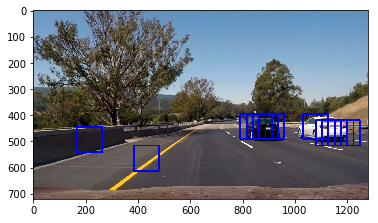

In [11]:
image = img

#scales = (1.5, 3, 4)
scales = [1.5, 3]
y_start_stop_ratio = [0.55, 0.9] # Min and max in y to search in slide_window()
ystart = np.int(img.shape[0] * y_start_stop_ratio[0])
ystop = np.int(image.shape[0] * y_start_stop_ratio[1])

out_img1, box_list = find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins, color_space,
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat, decision_prob=decision_prob)

if 0:
    scales = (2, 3)
    y_start_stop_ratio = [0.8, 0.9] # Min and max in y to search in slide_window()
    ystart = np.int(img.shape[0] * y_start_stop_ratio[0])
    ystop = np.int(image.shape[0] * y_start_stop_ratio[1])

    out_img2, box_list2 = find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins, color_space,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, decision_prob=decision_prob)

#box_list.extend(box_list2)
print(box_list)

out_img = np.copy(img)
for box in box_list:
    cv2.rectangle(out_img,(box[0][0], box[0][1]),(box[1][0], box[1][1]),(0,0,255),6) 

plt.imshow(out_img)
plt.show()


## False Positive by Heatmap

In [12]:
detect_threshold = 1


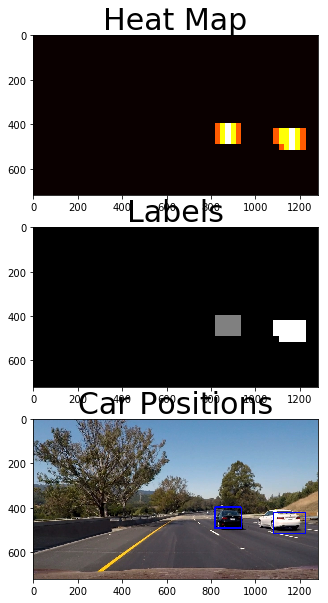

In [13]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = img
heat = np.zeros_like(image[:,:,0]).astype(np.float)

#print(box_list)
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat, box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, detect_threshold)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

draw_img = draw_labeled_bboxes(np.copy(image), labels)

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

ax1.imshow(heatmap, cmap='hot')
ax1.set_title('Heat Map', fontsize=30)
ax2.imshow(labels[0], cmap='gray')
ax2.set_title('Labels', fontsize=30)
ax3.imshow(draw_img)
ax3.set_title('Car Positions', fontsize=30)
plt.show()


## Video Implementation

### Six Consecutive Frames and Heatmap

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [25]:
class DetectCars():
    # Parameters
    #scales = [1.0, 2.0]
    scales = [1.5, 2.5]
    y_start_stop_ratio = [0.55, 0.90] # Cut 
    detect_threshold = 3.0 # 1.7
    # 1: two cars detected as one
    heatmap_union_threshold = 1.2 # Consider acc_count
    MAX_ACC_COUNT = 30
    decision_prob = 1.1
    HYSTERESYS_FACTOR = 40
    #heatmap_threshold = 4
    #MAX_HEATMAP_COUNT = 5
    if 0:
        # 12/27:12:12
        scales = [1.5, 2.5]
        y_start_stop_ratio = [0.55, 0.90] # Cut 
        detect_threshold = 3.0 # 1.7
        heatmap_union_threshold = 1.2 # Consider acc_count
        MAX_ACC_COUNT = 30
        decision_prob = 1.1
        HYSTERESYS_FACTOR = 40
        # 12/26/23:45
        scales = [1.5, 2.5]
        y_start_stop_ratio = [0.55, 0.90] # Cut 
        detect_threshold = 2.0 # 1.7
        # 1: two cars detected as one
        heatmap_union_threshold = 0.8 # Consider acc_count
        MAX_ACC_COUNT = 30
        decision_prob = 1.1
        HYSTERESYS_FACTOR = 20
        # 12/26/21:50
        scales = [1.5, 2.5]
        y_start_stop_ratio = [0.55, 0.90] # Cut 
        detect_threshold = 1.4 #6
        # 1: two cars detected as one
        heatmap_union_threshold = 1.2 # Consider acc_count
        MAX_ACC_COUNT = 30
        decision_prob = 1.1
        #12/26/17.00
        scales = [1.5, 2.5]
        y_start_stop_ratio = [0.55, 0.90] # Cut 
        detect_threshold = 1 #6
        # 1: two cars detected as one
        heatmap_union_threshold = 1 # Consider acc_count
        MAX_ACC_COUNT = 4
        decision_prob = 1.5

        heatmap_threshold = 4
        MAX_HEATMAP_COUNT = 5
        #12/26/01:36
        scales = [1.5]
        y_start_stop_ratio = [0.55, 0.90] # Cut 
        detect_threshold = 1 #6
        # 1: two cars detected as one
        heatmap_union_threshold = 1 # Consider acc_count
        MAX_ACC_COUNT = 4
        decision_prob = 1.15 
        #
        scales = [1.5]
        y_start_stop_ratio = [0.55, 0.90] # Cut 
        detect_threshold = 2 #6
        # 1: two cars detected as one
        heatmap_union_threshold = 0 # Consider acc_count
        MAX_ACC_COUNT = 4   
        decision_prob = 1.1
        # 05:
        scales = [1.5]
        y_start_stop_ratio = [0.55, 0.90] # Cut 
        detect_threshold = 3
        # 1: two cars detected as one
        heatmap_union_threshold = 1 # Consider acc_count
        MAX_ACC_COUNT = 6
        # 03: Union is too big; Sometimes false positive
        scales = [1.5]
        y_start_stop_ratio = [0.55, 0.95] # Min and max in y to search in slide_window()
        detect_threshold = 3
        # 1: two cars detected as one
        heatmap_union_threshold = 1
        MAX_ACC_COUNT = 4
        # 02:
        scales = (1.5, 2.5)
        y_start_stop_ratio = [0.55, 0.95] # Min and max in y to search in slide_window()
        detect_threshold = 2
        heatmap_union_threshold = 1
        MAX_ACC_COUNT = 4
    
    def __init__(self):
        self.bbox_list_acc = []
        self.acc_count = 0
        self.detected_heatmap = []
        
        #self.heatmap_acc = []
        #self.acc_heatmap_count = 0
        return

    def car_save_bbox_list(self, bbox_list):
        # Append new bbox_list, and pop the first list
        self.bbox_list_acc.append(bbox_list)
        if self.acc_count >= self.MAX_ACC_COUNT:
            self.bbox_list_acc.pop(0)
        else:
            self.acc_count = self.acc_count + 1
        return
    
    def car_get_bbox_list(self):
        bbox_list = []
        for i in self.bbox_list_acc:
            #print('i='+str(i))
            bbox_list.extend(i)

        return bbox_list

    def car_add_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        # Find union instead of intersection
        heatunion = np.zeros_like(heatmap).astype(np.float)
        for box in bbox_list:
            if (np.min(heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]]) >= \
                    self.heatmap_union_threshold * self.acc_count):
                heatunion[box[0][1]:box[1][1], box[0][0]:box[1][0]] \
                    = np.max(heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]])

        # Return updated heatmap
        return heatunion# Iterate through list of bboxes
    
    def car_apply_threshold(self, heatmap, threshold):
        if self.acc_count <= 1:
            self.detected_heatmap = np.zeros_like(heatmap).astype(np.float)
        heatmap = np.add(heatmap, self.detected_heatmap)
        
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        
        # Save final heatmap
        self.detected_heatmap = heatmap[heatmap >= 1] = self.HYSTERESYS_FACTOR
        # Return thresholded map
        return heatmap

    def car_save_heatmap(self, heatmap):
        # Append new heatmap, and pop the first list
        heatmap[heatmap > 1] = 1
        self.heatmap_acc.append(heatmap)
        if self.acc_heatmap_count >= self.MAX_HEATMAP_COUNT:
            self.heatmap_acc.pop(0)
        else:
            self.acc_heatmap_count = self.acc_heatmap_count + 1
        return
    
    def car_get_heatmap(self, heatmap_threshold):
        heatmap = np.sum(self.heatmap_acc, axis=0)
        heatmap[heatmap < heatmap_threshold] = 0
        return heatmap
    
    def car_draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        car_count = 0
        #box_detected = []
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            car_count = car_count + 1
            #box_detected.append(bbox)
        # Return the image
        return img, car_count #, box_detected

    def process_image(self, image):
        # NOTE: The output you return should be a color image (3 channel) for processing video below
        # TODO: put your pipeline here,
        # you should return the final output (image where lines are drawn on lanes)

        #reading in an image
        #image = mpimg.imread('test_images/solidWhiteRight.jpg')

        #printing out some stats and plotting
        print('This image is:', type(image), 'with dimensions:', image.shape)
        #plt.imshow(image)  # if you wanted to show a single color channel image called 'gray',
                            # for example, call as plt.imshow(gray, cmap='gray')

        ystart = np.int(image.shape[0] * self.y_start_stop_ratio[0])
        ystop = np.int(image.shape[0] * self.y_start_stop_ratio[1])

        out_img, box_list = find_cars(image, ystart, ystop, self.scales, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins, color_space,
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, decision_prob=self.decision_prob)

        if 0:
            box_list1.extend(box_list)
            #print(box_list1)
            out_img = np.copy(image)
            for box in box_list:
                cv2.rectangle(out_img,(box[0][0], box[0][1]),(box[1][0], box[1][1]),(0,0,255),6) 

        # Save box_list to accumulate
        self.car_save_bbox_list(box_list)
        # Get the accumulated bbox_list
        bbox_list = self.car_get_bbox_list()        
        print(len(bbox_list), self.acc_count)
        
        # Add heat to each box in box list
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = self.car_add_heat(heat, bbox_list)

        # Apply threshold to help remove false positives
        modified_threshold = np.max([self.detect_threshold, self.acc_count * self.detect_threshold // 1])
        print("th="+str(modified_threshold))
        heat = self.car_apply_threshold(heat, modified_threshold)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        #print(labels.shape)
        draw_img, car_count = self.car_draw_labeled_bboxes(np.copy(image), labels)
        
        # Apply additional moving average for decision ------------------------
        #print('heatmap'+str(heatmap.shape))
        #self.car_save_heatmap(heat)
        #heat = self.car_get_heatmap(self.heatmap_threshold)
        #print('heatmap'+str(heatmap.shape))
        
        # Visualize the heatmap when displaying    
        #heatmap = np.clip(heat, 0, 255)
        
        # Find final boxes from heatmap using label function
        #labels = label(heatmap)
        #print(labels.shape)
        #draw_ma_img, car_ma_count = self.car_draw_labeled_bboxes(np.copy(image), labels)
        print(car_count)
        #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        #ax1.imshow(draw_img)
        #ax1.set_title('Car Positions', fontsize=30)
        #ax2.imshow(heatmap, cmap='hot')
        #ax2.set_title('Heat Map', fontsize=30)
        #plt.show()            
            
        # ---------------------------------------------------------
        #draw_box_img = self.car_draw_labeled_bboxes(np.copy(image), box_list)
        draw_box_img = np.copy(image)
        for box in box_list:
            cv2.rectangle(draw_box_img, box[0], box[1], (0,0,255), 6)

        #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        #f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
        #ax1.imshow(image)
        #ax1.imshow(draw_box_img)
        #ax2.imshow(draw_img)
        #ax3.imshow(draw_ma_img)
        #plt.show()
        
        #return draw_ma_img
        return draw_img

    def process_video(self, image):
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        draw_img = self.process_image(image)
        #print(image)

        return draw_img

(720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
11 1
th=3.0
2


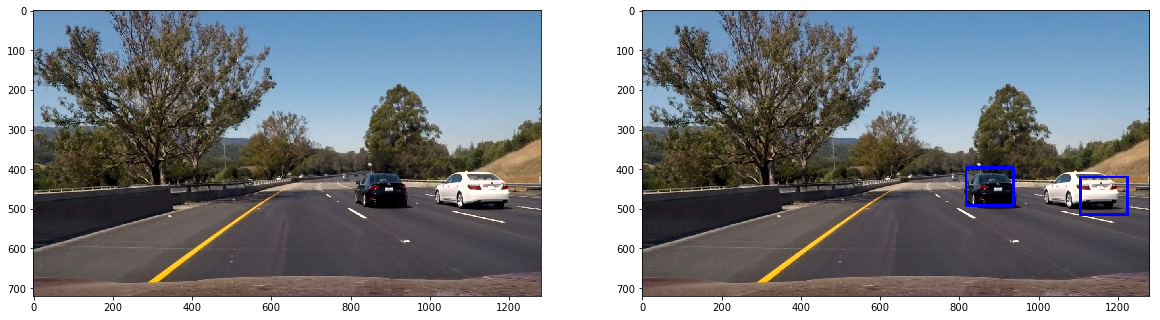

In [26]:
# Test undistortion on an image
img = mpimg.imread('test_images/test6.jpg')

print(img.shape)
#img_size = (img.shape[1], img.shape[0])

advImage = DetectCars()
img_out = advImage.process_image(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,15))
ax1.imshow(img)
ax2.imshow(img_out)
plt.show()


### test_video.mp4

In [ ]:
white_output = 'output_images/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")

AdvLine = DetectCars()
white_clip = clip1.fl_image(AdvLine.process_video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)